# NLP project work
Summary: Casting text classification to Graph Classification for Sentiment Analysis of Tweets
Members:

- Dell'Olio Domenico
- Delvecchio Giovanni Pio
- Disabato Raffaele

The project was developed in order to evaluate the effectiveness of Graph Neural network on a sentiment analysis task proposed in the challenge:
https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification?resource=download

We decided to implement and test various architectures, including commonly employed transformer-based architectures, in order to compare their performances.
These architectures were either already present at the state of the art or were obtained as a result of experiments.


## This notebook contains the following implementations:
- Definitions, training, tuning and testing procedures for Graph-based network:
    - Graph convolutional Network + classifier
    - Graph ATtention Network + classifier
    - LSTM + Graph Attention Network + classifier
    - BiLSTM + GAT + classifier

<a href="https://colab.research.google.com/github/GiovanniPioDelvecchio/GCNs_on_text/blob/issue%232/GNN_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# installs necessary libraries
!pip install stanza
!pip install torch-geometric
!pip install torchsummary
!pip install transformers

In [4]:
# cloning the repository
!git clone https://github.com/GiovanniPioDelvecchio/GCNs_on_text.git
%cd GCNs_on_text

Cloning into 'GCNs_on_text'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 106 (delta 48), reused 52 (delta 16), pack-reused 0
Receiving objects: 100% (106/106), 6.07 MiB | 10.48 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/GCNs_on_text
Branch 'issue-#5' set up to track remote branch 'issue-#5' from 'origin'.
Switched to a new branch 'issue-#5'


In [ ]:
# generic imports
import utils
from utils import Dataset_from_sentences
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
import pickle
import pandas as pd
from sklearn.metrics import classification_report
import time

# torch imports
import torch
from torch import save, load
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from functools import partial
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import PolynomialLR
from torch_geometric.nn.pool import global_max_pool
from torch.optim.lr_scheduler import OneCycleLR

# graph library imports
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, InMemoryDataset
from torch_geometric.utils import scatter
from torch_geometric.data import download_url
from torch_geometric.nn import GCNConv, GATv2Conv, global_mean_pool



In [2]:
# Utilities needed to set seeds for reproducibility

DEFAULT_RANDOM_SEED = 10
# basic random seed
def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
# torch random seed
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
# combine
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

seedEverything()

In [6]:
# loading google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# checking cuda availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.__version__)

cuda
2.2.0+cu121


The following cell was used to load the dataset where each token was encoded using BERT. Uncomment it and run it twice to use it.

In [ ]:
'''
tweet_list_train = []
sentiment_list_train = []
tweet_list_val = []
sentiment_list_val = []
tweet_list_test = []
sentiment_list_test = []
cv19_bert_data_train = utils.Dataset_from_sentences("train", "/content/processed_train/",
                                                     "/content/drive/MyDrive/GraphDataset/train/",
                                                     tweet_list_train, sentiment_list_train)
cv19_bert_data_val = utils.Dataset_from_sentences("val", "/content/processed_val/",
                                                     "/content/drive/MyDrive/GraphDataset/val/",
                                                     tweet_list_train, sentiment_list_train)
cv19_bert_data_test = utils.Dataset_from_sentences("test", "/content/processed_test/",
                                                    "/content/drive/MyDrive/GraphDataset/test/",
                                                    tweet_list_test, sentiment_list_test)

print("Loaded training dataset:")
print(cv19_bert_data_train)
print("Loaded val dataset:")
print(cv19_bert_data_val)
print("Loaded test dataset:")
print(cv19_bert_data_test)
'''

For the GLoVe based models, run the following cell instead.

In [5]:

with open('./NewDataset/processed_train/graph_train.pkl', 'rb') as dt_file:
    cv19_graph_data_train = pickle.load(dt_file)

with open('./NewDataset/processed_val/graph_val.pkl', 'rb') as dv_file:
    cv19_graph_data_val = pickle.load(dv_file)

with open('./NewDataset/processed_test/graph_test.pkl', 'rb') as dtest_file:
    cv19_graph_data_test = pickle.load(dtest_file)

print("Loaded training dataset:")
print(cv19_graph_data_train)
print("Loaded val dataset:")
print(cv19_graph_data_val)
print("Loaded test dataset:")
print(cv19_graph_data_test)

Loaded training dataset:
Dataset_from_sentences(25534)
Loaded val dataset:
Dataset_from_sentences(6384)
Loaded test dataset:
Dataset_from_sentences(7980)


## Model definitions

In the following cell we write down the declaration for the simple graph convolutional network.

As briefly mentioned, it consists of three GCN layer + linear layer parallel blocks followed by a linear layer used as classifier.

In [ ]:
class GCN(torch.nn.Module):
  """
     Graph Convolutional Network class
  """
  def __init__(self, dim_in, n_filters, dim_out):
    """
        Constructor method for the GCN class.
        :param dim_in: number of node features
        :param n_fiters: number of GCN filters to be used for each layer
        :param dim_out: dimension of the output
    """
    super().__init__()

    self.gcn_list_1 = torch.nn.ModuleList([GCNConv(dim_in, dim_in, add_self_loops = True)
                                         for i in range(0, n_filters)])
    self.gcn_list_2 = torch.nn.ModuleList([GCNConv(dim_in, dim_in, add_self_loops = True)
                                         for i in range(0, n_filters)])
    self.gcn_list_3 = torch.nn.ModuleList([GCNConv(dim_in, dim_in, add_self_loops = True)
                                         for i in range(0, n_filters)])
    self.l_list = torch.nn.ModuleList([Linear(dim_in, 1)
                                      for i in range(0, n_filters)])
    self.classifier = Linear(n_filters, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=1e-3,
                                      weight_decay=5e-5)

  def forward(self, x, edge_index, batch, enable_log = False):
    """
    Forward function.
    :param x: graph node features. Corresponds to data.x, where data is a point sampled from the graph dataset
    :param edge_index: edge index data. corresponds to data.edge_index, where data is a point sampled from the graph dataset
    :param batch: data batch containing all the graph structures.
    :param enable_log: enables some prints to visualize hidden graphs
    """
    if enable_log:
        utils.visualize_hidden_graph(x, edge_index)

    h_list = []
    for i, gcn_l in enumerate(self.gcn_list_1):
        h = x + gcn_l(x, edge_index)
        h = h.tanh()
        h = h + self.gcn_list_2[i](h, edge_index)
        h = h.tanh()
        h = h + self.gcn_list_3[i](h, edge_index)
        if enable_log:
            print("h shape: " + str(h.shape))
            utils.visualize_hidden_graph(h, edge_index)
        h = global_mean_pool(h, batch)
        h = self.l_list[i](h)
        h_list.append(h)

    h_layers = torch.hstack(h_list)
    h_layers = self.classifier(h_layers)

    return h_layers

Here we put the definition of the Graph ATtention network, which is virtually equal to the previous one, but employs GAT layers instead of GCNs.

In [ ]:
# actual GAT class
class GAT(torch.nn.Module):
  """
    Graph Attention Network class.
  """
  def __init__(self, dim_in, n_filters, dim_out, heads= 8):
    """
      Constructor method for the GAT class.
        :param dim_in: number of node features
        :param n_fiters: number of GAT filters to be used for each layer
        :param dim_out: dimension of the output
        :param heads: number of attention heads to be used by the GAT convolution layers
    """
    super().__init__()

    self.gat_list_1 = torch.nn.ModuleList([GATv2Conv(dim_in, dim_in // heads, heads = heads)
                                         for i in range(0, n_filters)])
    self.gat_list_2 = torch.nn.ModuleList([GATv2Conv(dim_in, dim_in // heads, heads = heads)
                                         for i in range(0, n_filters)])
    self.gat_list_3 = torch.nn.ModuleList([GATv2Conv(dim_in, dim_in // heads, heads = heads)
                                         for i in range(0, n_filters)])

    self.l_list = torch.nn.ModuleList([Linear(dim_in, 1)
                                      for i in range(0, n_filters)])
    self.classifier = Linear(n_filters, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=1e-3,
                                      weight_decay=5e-5)

  def forward(self, x, edge_index, batch, enable_log = False):
    """
    Forward function.
    :param x: graph node features. Corresponds to data.x, where data is a point sampled from the graph dataset
    :param edge_index: edge index data. corresponds to data.edge_index, where data is a point sampled from the graph dataset
    :param batch: data batch containing all the graph structures.
    :param enable_log: enables some prints to visualize hidden graphs
    """
    if enable_log:
        utils.visualize_hidden_graph(x, edge_index)

    h_list = []
    for i, gat_l in enumerate(self.gat_list_1):
        h = x + gat_l(x, edge_index)
        h = h.tanh()
        h = h + self.gat_list_2[i](h, edge_index)
        h = h.tanh()
        h = h + self.gat_list_3[i](h, edge_index)
        if enable_log:
            print("h shape: " + str(h.shape))
            utils.visualize_hidden_graph(h, edge_index)
        h = global_mean_pool(h, batch)
        h = self.l_list[i](h)
        h_list.append(h)

    h_layers = torch.hstack(h_list)
    h_layers = self.classifier(h_layers)
    return h_layers

The following model presents a slight modification in the architecture w.r.t. the one above. 

In particular, we introduce a LSTM layer at the beginning of the network to further enforce temporal dependency on the encoded tokens.


In [3]:
class GAT_lstm(torch.nn.Module):
  """
    LSTM + Graph Attention Network class.
  """
  def __init__(self, dim_in, n_filters, dim_out, heads= 8):
    """
        Constructor method for the GAT class.
        :param dim_in: number of node features
        :param n_fiters: number of GAT filters to be used for each layer
        :param dim_out: dimension of the output
        :param heads: number of attention heads to be used by the GAT convolution layers
    """
    super().__init__()

    self.gat_list_1 = torch.nn.ModuleList([GATv2Conv(dim_in, dim_in // heads, heads = heads)
                                         for i in range(0, n_filters)])
    self.gat_list_2 = torch.nn.ModuleList([GATv2Conv(dim_in, dim_in // heads, heads = heads)
                                         for i in range(0, n_filters)])
    self.gat_list_3 = torch.nn.ModuleList([GATv2Conv(dim_in, dim_in // heads, heads = heads)
                                         for i in range(0, n_filters)])

    self.l_list = torch.nn.ModuleList([Linear(dim_in, 1)
                                      for i in range(0, n_filters)])

    self.h0 = torch.randn(1, dim_in)
    self.c0 = torch.randn(1, dim_in)
    self.h0 = self.h0.to(device)
    self.c0 = self.c0.to(device)
    self.lstm = nn.LSTM(dim_in, dim_in, num_layers = 1, dropout = 0, bidirectional = False)
    self.classifier = Linear(n_filters, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=1e-3,
                                      weight_decay=5e-5)

  def forward(self, x, edge_index, batch, enable_log = False):
    """
    Forward function.
    :param x: graph node features. Corresponds to data.x, where data is a point sampled from the graph dataset
    :param edge_index: edge index data. corresponds to data.edge_index, where data is a point sampled from the graph dataset
    :param batch: data batch containing all the graph structures.
    :param enable_log: enables some prints to visualize hidden graphs
    """
    stack_list = []
    batch_elements = batch.unique()
    # pass each graph through lstm
    for elem in batch_elements:
      idxs = torch.where(batch == elem)
      current_graph = x[idxs]
      self.lstm.flatten_parameters()
      to_stack, (hn, cn) = self.lstm(current_graph, (self.h0, self.c0))
      stack_list.append(to_stack)

    h_to_gat = torch.vstack(stack_list)

    h_list = []
    # pass each graph in the three gat layers
    for i, gat_l in enumerate(self.gat_list_1):
        h = h_to_gat + gat_l(h_to_gat, edge_index)
        h = h.tanh()
        h = h + self.gat_list_2[i](h, edge_index)
        h = h.tanh()
        h = h + self.gat_list_3[i](h, edge_index)
        if enable_log:
            print("h shape: " + str(h.shape))
            utils.visualize_hidden_graph(h, edge_index)
        h = global_mean_pool(h, batch)
        h = self.l_list[i](h)
        h_list.append(h)

    # apply classification
    h_layers = torch.hstack(h_list)
    h_layers = self.classifier(h_layers)
    return h_layers

Lastly, we introduce another variation on the previous model, where the first LSTM layer is Bi-Directional.

In [ ]:
# actual GAT class
class GAT_bilstm(torch.nn.Module):
  """
    Bi-LSTM + Graph Attention Network class.
  """
  def __init__(self, dim_in, n_filters, dim_out, dim_out_lstm=None, heads=8):
    super().__init__()
    """
        Constructor method for the GAT class.
        :param dim_in: number of node features
        :param n_fiters: number of GAT filters to be used for each layer
        :param dim_out: dimension of the output
        :param dim_out_lstm: dimension of the hidden map returned by the LSTM. Its double must be divisible by heads
        :param heads: number of attention heads to be used by the GAT convolution layers
    """
    if dim_out_lstm == None:
      dim_out_lstm = dim_in

    if ((dim_in * 2) % heads) != 0:
      raise ValueError(f"Number of input dimensions*2 must be divisible by the number of heads")
    self.gat_list_1 = torch.nn.ModuleList([GATv2Conv(dim_out_lstm * 2, (dim_out_lstm * 2) // heads, heads = heads)
                                         for i in range(0, n_filters)])
    self.gat_list_2 = torch.nn.ModuleList([GATv2Conv(dim_out_lstm * 2, (dim_out_lstm * 2) // heads, heads = heads)
                                         for i in range(0, n_filters)])
    self.gat_list_3 = torch.nn.ModuleList([GATv2Conv(dim_out_lstm * 2, (dim_out_lstm * 2) // heads, heads = heads)
                                         for i in range(0, n_filters)])

    self.l_list = torch.nn.ModuleList([Linear(dim_out_lstm * 2, 1)
                                      for i in range(0, n_filters)])

    self.h0 = torch.randn(2, dim_out_lstm)
    self.c0 = torch.randn(2, dim_out_lstm)
    self.h0 = self.h0.to(device)
    self.c0 = self.c0.to(device)
    self.lstm = nn.LSTM(dim_in, dim_out_lstm, num_layers = 1, dropout = 0, bidirectional = True)
    self.classifier = Linear(n_filters, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=1e-3,
                                      weight_decay=5e-5)

  def forward(self, x, edge_index, batch, enable_log = False):
    """
    Forward function.
    :param x: graph node features. Corresponds to data.x, where data is a point sampled from the graph dataset
    :param edge_index: edge index data. corresponds to data.edge_index, where data is a point sampled from the graph dataset
    :param batch: data batch containing all the graph structures.
    :param enable_log: enables some prints to visualize hidden graphs
    """
    stack_list = []
    batch_elements = batch.unique()
    for elem in batch_elements:
      idxs = torch.where(batch == elem)
      current_graph = x[idxs]
      self.lstm.flatten_parameters()
      to_stack, (hn, cn) = self.lstm(current_graph, (self.h0, self.c0))
      stack_list.append(to_stack)

    h_to_gat = torch.vstack(stack_list)

    h_list = []
    for i, gat_l in enumerate(self.gat_list_1):
        h = h_to_gat +  gat_l(h_to_gat, edge_index)
        h = h.tanh()
        h = h + self.gat_list_2[i](h, edge_index)
        h = h.tanh()
        h = h + self.gat_list_3[i](h, edge_index)
        if enable_log:
            print("h shape: " + str(h.shape))
            utils.visualize_hidden_graph(h, edge_index)
        h = global_mean_pool(h, batch)
        h = self.l_list[i](h)
        h_list.append(h)

    h_layers = torch.hstack(h_list)
    h_layers = self.classifier(h_layers)
    return h_layers

## Training and Tuning

Then we define some helper function and classes, like the one implementing the Early Stopping criterion, loss plotting and training procedure.

In [28]:
class EarlyStopper:
  """
    Simple EarlyStopper class
  """
  def __init__(self, patience=1, min_delta=0):
      """
      :param patience: number of epochs to wait if the loss doesn't decrease.
      :min_delta: minimum fluctuation of the loss to be considered as consistent change
      """
      self.patience = patience
      self.min_delta = min_delta
      self.counter = 0
      self.min_validation_loss = np.inf

  def early_stop(self, validation_loss):
      """
      early stopping function.
      :param validation_loss: value of the loss computed on the validation set
      """
      if validation_loss < self.min_validation_loss:
          self.min_validation_loss = validation_loss
          self.counter = 0
      elif validation_loss > (self.min_validation_loss + self.min_delta):
          self.counter += 1
          if self.counter >= self.patience:
              return True
      return False

def plot_losses(train_losses, val_losses):
    """
    Plots the training and validation losses over the course of training.
    :param train_losses: A list of training losses.
    :param val_losses: A list of validation losses.
    """
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def accuracy(pred_y, y):
    """
    Calculates accuracy.
    :param pred_y: tensor containing the predictions for the split.
    :param y: tensor containing the ground truths for the split
    """
    return ((pred_y == y).sum() / len(y)).item()

In [29]:
def train(model, strat_train, strat_val, partial_scheduler, epochs = 30, batch_size = 30, print_every = 1, path='Model'):
    """
        Trains a GNN model and return the trained model.
        :param model: Torch model to be trained.
        :param strat_train: train split to be loaded into a torch DataLoader
        :param strat_val: validation split to be loaded into a torch DataLoader
        :param partial_scheduler: learning rate scheduler wrappped in a functools partial
        :param epochs: number of training epochs
        :param batch_size: batch dimensi0on
        :param print_every: interval of epochs to wait when logging partial results
        :param path: string containing the path to the model
    """

    batch_size = batch_size
    criterion = torch.nn.CrossEntropyLoss(label_smoothing = 0.01)
    optimizer = model.optimizer
    scheduler = partial_scheduler(optimizer)
    print(type(scheduler))
    loader_train =  DataLoader(strat_train.data_list, batch_size=batch_size, shuffle=True)
    loader_val = DataLoader(strat_val.data_list, batch_size=batch_size, shuffle=True)
    model.train()

    early_stopper = EarlyStopper(patience=10, min_delta=0.2)

    train_losses = []
    val_losses = []

    best_acc_val = 0
    epochs_to_return = 0
    start_t = time.time()

    for epoch in range(epochs+1):
      mean_loss_train = 0
      mean_acc_train = 0
      
      for i, batch in enumerate(loader_train):
        # Training
        out = model(batch.x.to(device), batch.edge_index.to(device), batch.batch.to(device))
        loss_train = criterion(out, batch.y.long().to(device))
        mean_loss_train += loss_train.item()

        acc_train = accuracy(out.argmax(dim=1), batch.y.to(device))
        mean_acc_train += acc_train
        # backward + scheduler/oprimizers step
        loss_train.backward()
        with torch.no_grad():
            optimizer.step()
            if type(scheduler) == OneCycleLR:
                scheduler.step()
            optimizer.zero_grad()
      print(i)
      mean_loss_train /= (i + 1)
      mean_acc_train /= (i + 1)
      train_losses.append(mean_loss_train)
      if type(scheduler) != OneCycleLR:
          scheduler.step()
      
      # evaluation
      mean_loss_val = 0
      mean_acc_val = 0
      model.eval()
      with torch.no_grad():
          for i, batch in enumerate(loader_val):
            out = model(batch.x.to(device), batch.edge_index.to(device), batch.batch.to(device))
            loss_val = criterion(out, batch.y.long().to(device))
            mean_loss_val += loss_val.item()
            acc_val = accuracy(out.argmax(dim=1), batch.y.to(device))
            mean_acc_val += acc_val
            #visualize_embedding(embed, batch.y, epoch, loss_val)
          mean_loss_val /= (i + 1)
          mean_acc_val /= (i + 1)
          val_losses.append(mean_loss_val)
          if mean_acc_val > best_acc_val:
                # best checkpoint saving
                best_acc_val = mean_acc_val
                best_model_state_dict = model.state_dict
                torch.save(model.state_dict(), path + '_ckpt')
                epochs_to_return = epoch

      if(epoch % print_every == 0):
        print(f'Epoch {epoch:>3} | Train Loss: {mean_loss_train:.3f} | Train Acc: '
              f'{mean_acc_train*100:>6.2f}%')
        print(f'Epoch {epoch:>3} | Val Loss: {mean_loss_val:.3f} | Val Acc: '
              f'{mean_acc_val*100:>6.2f}%')
        print("learning rate: " + str(scheduler.get_last_lr()))
        print("elapsed time: %.2f" % (time.time() - start_t))
        start_t = time.time()
      if early_stopper.early_stop(mean_loss_val):
        print("early stopping was triggered, final loss:" + str(mean_loss_val))
        break
    plot_losses(train_losses, val_losses)
    return best_model_state_dict, best_acc_val, epochs_to_return

Then we continue defining the functions used to generate the list of learning rate scheduler to be applied for hyper parameter tuning.

The full list contains:
- Two Polynomial Schedulers with power in \{2, 3\};
- Two Step Learning rate scheduler with step size equal to \#epochs/x with x in \{3, 4\} and gamma = 0.5;
- Three Cosine Annealing schedulers with <code>min_lr</code> in \{1e-6, 1e-7, 1e-8\};
- One OneCycle scheduer with <code>max_lr</code>= 1e-3.

Some of them where discarded (commented) during successive runs due to their generally lower performances.


In [30]:
def get_lr(optimizer):
    """
    gets current learning rate from the optimizer
    :param optimizer: a torch.optim Optimizer
    """
    for param_group in optimizer.param_groups:
        return param_group['lr']

def build_scheduler_list(epochs = 30, max_lr = 1e-3, num_batches = 1):
    """
    Builds a scheduler list to be tested.
    :param epochs: epochs to be used during training
    :param max_lr: upper learning rate bound for OneCycleLR scheduler
    :param num_batches: number of steps within an epoch
    """
    schedulers = []

    #schedulers += [partial(PolynomialLR,
    #                     total_iters = epochs, # The number of steps that the scheduler decays the learning rate.
    #                     power = i) for i in range(2, 3)] # The power of the polynomial. # 2 to 1
    schedulers += [partial(StepLR,
                                  step_size=epochs//i, gamma=0.5) for i in range(3, 4)] # for i in range(3, 5)
    schedulers += [partial(CosineAnnealingLR,
                              T_max = epochs, # Maximum number of iterations.
                              eta_min = min_lr) for min_lr in [1e-8]] # Minimum learning rate, tested values were 1e-6, 1e-7, 1e-8
    #schedulers += [partial(OneCycleLR,
    #                   max_lr = max_lr, # Upper learning rate boundaries in the cycle for each parameter group
    #                   steps_per_epoch = num_batches, # The number of steps per epoch to train for.
    #                   epochs = epochs, # The number of epochs to train for.
    #                   anneal_strategy = 'cos')] # Specifies the annealing strategy
    return schedulers

The following function implements an hyperparameter tuning procedure, focused mainly on the choice of the learning rate scheduler.

We made this choice because the architectural patterns were tested one by one and, during the first tests, the learning rate was remarkably the most impactful
hyperparameter on the performances.

In [31]:
def hyperparameter_tuning(model, strat_train, strat_val, scheduler_list, batch_size = 30, epochs = 30):
    """
    Function performing hyperparameter tuning (testing different schedulers)
    :param model: model to be tuned
    :param strat_train: train split to be loaded into a torch DataLoader
    :param strat_val: validation split to be loaded into a torch DataLoader
    :param scheduler_list: list of schedulers to be tested
    :param batch_size: dimension of the batch
    :param epochs: number of training epochs
    """
    print(f"batch size: {batch_size}")
    best_valid_acc = 0
    best_model = []
    best_hyper_params = []
    best_val_acc = 0
    i = 1
    for partial_scheduler in scheduler_list:
        #path = f'/content/drive/MyDrive/graphmod/GAT_best_{partial_scheduler.func.__name__}_{i}'
        # trains the model with given scheduler and saves best result
        path = f'./GAT_best_{partial_scheduler.func.__name__}_{i}'
        model_out, mean_acc_val, epoch = train(copy.deepcopy(model), strat_train, strat_val,
                                               partial_scheduler, epochs, batch_size = batch_size, print_every=1, path=path)
        torch.save(model_out, path)
        # also selects and returns the best model among the schedulers
        if mean_acc_val > best_val_acc:
            best_val_acc = mean_acc_val
            best_model = model_out
            best_hyper_params = [partial_scheduler, epoch]
            print(f"Improved result: acc {best_val_acc:.3f}, scheduler:\n {partial_scheduler}\nepoch: {epoch}")
        i = i + 1
    return best_hyper_params, best_model

The first presented model is the BiLSTM + GAT using the dataset with BERT-encoded tokens.

We chose the following parameters:
- dim_in = 768;
- n_filters = 10;
- dim_out = 5;
- dim_out_lstm = 192.

While as hyperparameters we put:
- maximum number of epochs to 300,
- early stopping with patience equal to 10 and min_delta = 0.2;
- batch size to 256 (the biggest batch size we could use with the given resources).

In [ ]:

model_bertgat = GAT_bilstm(cv19_bert_data_train.num_node_features,
                cv19_bert_data_train.num_classes*2,
                cv19_bert_data_train.num_classes,
                dim_out_lstm=cv19_bert_data_train.num_node_features//4,
                heads = 12).to(device)
print(model_bertgat)

In [ ]:
#cv19_bert_data_train = cv19_bert_data_train.to(device)
#cv19_bert_data_val = cv19_bert_data_val.to(device)

0.001
[functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=300, power=2), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=100, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=75, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-06), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-07), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-08), functools.partial(<class 'torch.optim.lr_scheduler.OneCycleLR'>, max_lr=0.001, steps_per_epoch=103, epochs=300, anneal_strategy='cos')]
batch size: 256
<class 'torch.optim.lr_scheduler.PolynomialLR'>
99
Epoch   0 | Train Loss: 1.365 | Train Acc:  39.78%
Epoch   0 | Val Loss: 1.237 | Val Acc:  46.07%
learning rate: [0.0009933444444444445]
elapsed time: 124.02
99
Epoch   1 | Train Loss: 1.170 | Train Acc:  50.06%
Epoch   1 | 

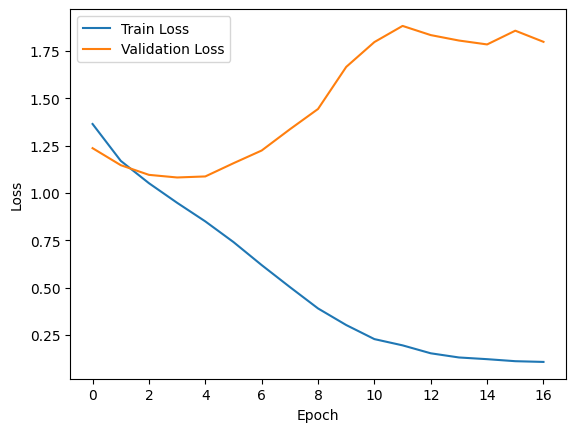

Improved result: acc 0.578, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=300, power=2)
epoch: 11
<class 'torch.optim.lr_scheduler.StepLR'>
99
Epoch   0 | Train Loss: 1.343 | Train Acc:  41.23%
Epoch   0 | Val Loss: 1.221 | Val Acc:  47.06%
learning rate: [0.001]
elapsed time: 124.93
99
Epoch   1 | Train Loss: 1.170 | Train Acc:  49.69%
Epoch   1 | Val Loss: 1.152 | Val Acc:  51.32%
learning rate: [0.001]
elapsed time: 124.06
99
Epoch   2 | Train Loss: 1.057 | Train Acc:  55.55%
Epoch   2 | Val Loss: 1.082 | Val Acc:  54.53%
learning rate: [0.001]
elapsed time: 124.07
99
Epoch   3 | Train Loss: 0.952 | Train Acc:  61.29%
Epoch   3 | Val Loss: 1.062 | Val Acc:  55.84%
learning rate: [0.001]
elapsed time: 123.58
99
Epoch   4 | Train Loss: 0.851 | Train Acc:  66.34%
Epoch   4 | Val Loss: 1.069 | Val Acc:  57.33%
learning rate: [0.001]
elapsed time: 123.65
99
Epoch   5 | Train Loss: 0.749 | Train Acc:  71.53%
Epoch   5 | Val Loss: 1.138 | Val Ac

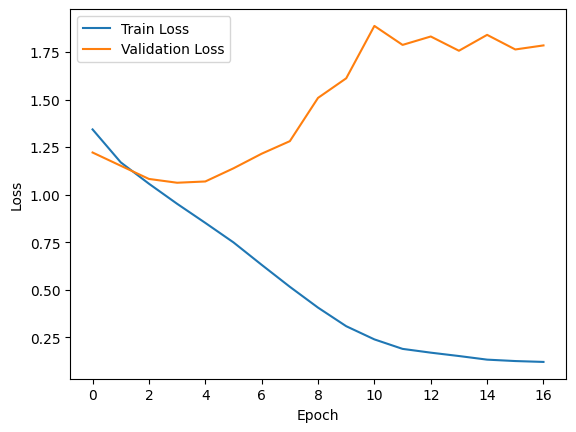

Improved result: acc 0.582, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=100, gamma=0.5)
epoch: 9
<class 'torch.optim.lr_scheduler.StepLR'>
99
Epoch   0 | Train Loss: 1.362 | Train Acc:  39.75%
Epoch   0 | Val Loss: 1.239 | Val Acc:  46.30%
learning rate: [0.001]
elapsed time: 123.78
99
Epoch   1 | Train Loss: 1.175 | Train Acc:  49.83%
Epoch   1 | Val Loss: 1.152 | Val Acc:  50.75%
learning rate: [0.001]
elapsed time: 124.17
99
Epoch   2 | Train Loss: 1.074 | Train Acc:  55.00%
Epoch   2 | Val Loss: 1.098 | Val Acc:  54.14%
learning rate: [0.001]
elapsed time: 123.58
99
Epoch   3 | Train Loss: 0.960 | Train Acc:  60.90%
Epoch   3 | Val Loss: 1.079 | Val Acc:  56.49%
learning rate: [0.001]
elapsed time: 124.30
99
Epoch   4 | Train Loss: 0.869 | Train Acc:  65.35%
Epoch   4 | Val Loss: 1.046 | Val Acc:  57.29%
learning rate: [0.001]
elapsed time: 123.86
99
Epoch   5 | Train Loss: 0.747 | Train Acc:  71.49%
Epoch   5 | Val Loss: 1.134 | Val Acc:  56.

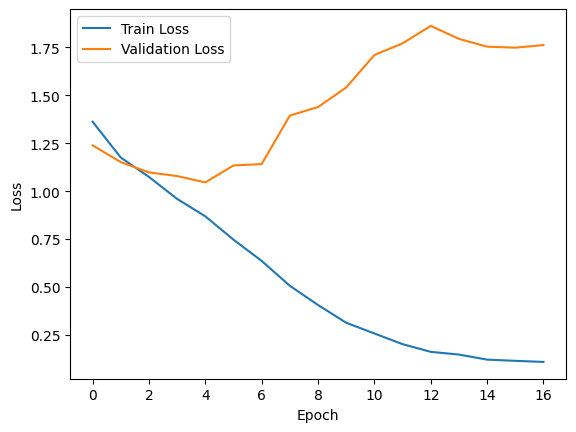

<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
99
Epoch   0 | Train Loss: 1.364 | Train Acc:  39.93%
Epoch   0 | Val Loss: 1.239 | Val Acc:  46.62%
learning rate: [0.0009999726120980734]
elapsed time: 124.53
99
Epoch   1 | Train Loss: 1.168 | Train Acc:  50.05%
Epoch   1 | Val Loss: 1.146 | Val Acc:  51.77%
learning rate: [0.0009998904513956854]
elapsed time: 124.23
99
Epoch   2 | Train Loss: 1.054 | Train Acc:  56.02%
Epoch   2 | Val Loss: 1.081 | Val Acc:  54.74%
learning rate: [0.0009997535269026829]
elapsed time: 123.84
99
Epoch   3 | Train Loss: 0.947 | Train Acc:  61.54%
Epoch   3 | Val Loss: 1.051 | Val Acc:  56.90%
learning rate: [0.0009995618536343797]
elapsed time: 124.10
99
Epoch   4 | Train Loss: 0.849 | Train Acc:  66.52%
Epoch   4 | Val Loss: 1.055 | Val Acc:  58.99%
learning rate: [0.0009993154526099096]
elapsed time: 124.44
99
Epoch   5 | Train Loss: 0.745 | Train Acc:  71.94%
Epoch   5 | Val Loss: 1.086 | Val Acc:  57.92%
learning rate: [0.0009990143508499217]
el

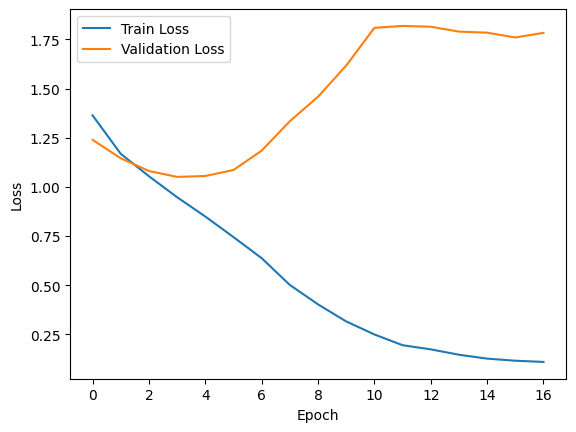

Improved result: acc 0.590, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-06)
epoch: 4
<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
99
Epoch   0 | Train Loss: 1.361 | Train Acc:  39.77%
Epoch   0 | Val Loss: 1.229 | Val Acc:  47.23%
learning rate: [0.0009999725874242878]
elapsed time: 123.57
99
Epoch   1 | Train Loss: 1.170 | Train Acc:  49.67%
Epoch   1 | Val Loss: 1.196 | Val Acc:  48.99%
learning rate: [0.000999890352703249]
elapsed time: 123.29
99
Epoch   2 | Train Loss: 1.061 | Train Acc:  55.71%
Epoch   2 | Val Loss: 1.076 | Val Acc:  55.29%
learning rate: [0.0009997533048548475]
elapsed time: 124.84
99
Epoch   3 | Train Loss: 0.960 | Train Acc:  61.20%
Epoch   3 | Val Loss: 1.070 | Val Acc:  56.32%
learning rate: [0.0009995614589079242]
elapsed time: 123.45
99
Epoch   4 | Train Loss: 0.850 | Train Acc:  66.71%
Epoch   4 | Val Loss: 1.089 | Val Acc:  55.29%
learning rate: [0.0009993148359005491]
elapsed time: 123

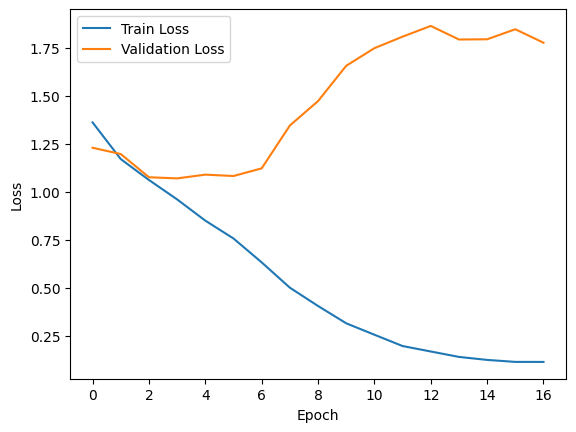

Improved result: acc 0.596, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-07)
epoch: 6
<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
99
Epoch   0 | Train Loss: 1.348 | Train Acc:  40.76%
Epoch   0 | Val Loss: 1.232 | Val Acc:  46.62%
learning rate: [0.0009999725849569093]
elapsed time: 124.93
99
Epoch   1 | Train Loss: 1.165 | Train Acc:  49.92%
Epoch   1 | Val Loss: 1.149 | Val Acc:  51.90%
learning rate: [0.0009998903428340053]
elapsed time: 124.25
99
Epoch   2 | Train Loss: 1.056 | Train Acc:  55.99%
Epoch   2 | Val Loss: 1.075 | Val Acc:  55.77%
learning rate: [0.0009997532826500639]
elapsed time: 124.87
99
Epoch   3 | Train Loss: 0.961 | Train Acc:  60.66%
Epoch   3 | Val Loss: 1.074 | Val Acc:  55.37%
learning rate: [0.0009995614194352785]
elapsed time: 124.18
99
Epoch   4 | Train Loss: 0.859 | Train Acc:  65.84%
Epoch   4 | Val Loss: 1.055 | Val Acc:  58.15%
learning rate: [0.000999314774229613]
elapsed time: 125

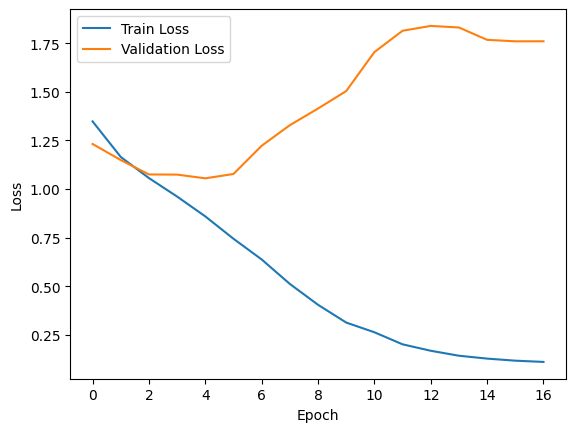

<class 'torch.optim.lr_scheduler.OneCycleLR'>
99
Epoch   0 | Train Loss: 1.501 | Train Acc:  32.40%
Epoch   0 | Val Loss: 1.418 | Val Acc:  37.52%
learning rate: [4.027567897599423e-05]
elapsed time: 124.91
99
Epoch   1 | Train Loss: 1.376 | Train Acc:  40.05%
Epoch   1 | Val Loss: 1.333 | Val Acc:  41.98%
learning rate: [4.110239924190267e-05]
elapsed time: 124.46
99
Epoch   2 | Train Loss: 1.295 | Train Acc:  43.98%
Epoch   2 | Val Loss: 1.280 | Val Acc:  44.36%
learning rate: [4.24792111752407e-05]
elapsed time: 124.29
99
Epoch   3 | Train Loss: 1.246 | Train Acc:  46.14%
Epoch   3 | Val Loss: 1.259 | Val Acc:  45.56%
learning rate: [4.440453328390852e-05]
elapsed time: 124.09
99
Epoch   4 | Train Loss: 1.223 | Train Acc:  47.68%
Epoch   4 | Val Loss: 1.243 | Val Acc:  46.88%
learning rate: [4.687615402279219e-05]
elapsed time: 123.89
99
Epoch   5 | Train Loss: 1.196 | Train Acc:  49.10%
Epoch   5 | Val Loss: 1.225 | Val Acc:  47.71%
learning rate: [4.989123433408191e-05]
elapsed ti

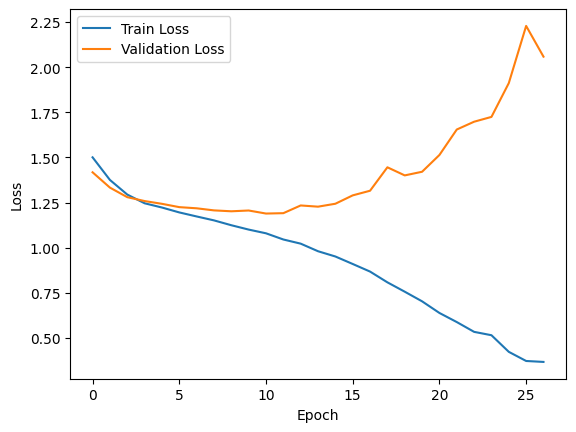

In [ ]:
epochs = 300
batch_size = 256
print(get_lr(model_bertgat.optimizer))
scheduler_list = build_scheduler_list(epochs=epochs,
                                      num_batches=(len(cv19_bert_data_train.data_list)//batch_size) + 4)
print(scheduler_list)
trained_gat = hyperparameter_tuning(model_bertgat, cv19_bert_data_train,
                                    cv19_bert_data_val, scheduler_list,
                                    batch_size = batch_size, epochs = epochs)

The best Bi-LSTM + GAT (BERT) model was obtained with the Cosine Annealing learning rate scheduler with eta_min = 1e-07 and T_max=300 after 6 epochs.

The accuracy results on the validation set was still low w.r.t. the GloVe counterparts, so we didn't explore more on this model.

Then, the next presented model is the one employing GCNs.

The chosen parameters were:
- dim_in = 50;
- n_filters = 10;
- dim_out = 5;

While as hyperparameters we put:
- maximum number of epochs to 30,
- early stopping with patience equal to 10 and min_delta = 0.2;
- batch size to 128.

In [ ]:
cv19_graph_data_train = cv19_graph_data_train.to(device)
cv19_graph_data_val = cv19_graph_data_val.to(device)

In [ ]:
model_gcn = GCN(cv19_graph_data_train.num_node_features,
                cv19_graph_data_train.num_classes*2,
                cv19_graph_data_train.num_classes).to(device)
print(model_gcn)

GCN(
  (first_linear): Linear(in_features=50, out_features=50, bias=True)
  (gcn_list_1): ModuleList(
    (0-9): 10 x GCNConv(50, 50)
  )
  (gcn_list_2): ModuleList(
    (0-9): 10 x GCNConv(50, 50)
  )
  (gcn_list_3): ModuleList(
    (0-9): 10 x GCNConv(50, 50)
  )
  (l_list): ModuleList(
    (0-9): 10 x Linear(in_features=50, out_features=1, bias=True)
  )
  (classifier): Linear(in_features=10, out_features=5, bias=True)
)


In [ ]:
print(get_lr(model_gcn.optimizer))
scheduler_list = build_scheduler_list()
print(scheduler_list)

In [ ]:
trained_gcn = hyperparameter_tuning(model_gcn, cv19_graph_data_train, cv19_graph_data_val, scheduler_list, batch_size = 128)

The training was performed on another script, but the best results were obtained with the Polynomial scheduler with power = 2.

The reported best val. accuracy was 58.29%, still considerably worse than other models.

We then follow up with training the LSTM + GAT with GLoVe embeddings.

The chosen parameters were:
- dim_in = 100;
- n_filters = 10;
- dim_out = 5;
- heads = 10;

While as hyperparameters we put:
- maximum number of epochs to 300;
- early stopping with patience equal to 10 and min_delta = 0.2;
- batch size to 256.

In [ ]:
model_gat = GAT_lstm(cv19_graph_data_train.num_node_features,
                cv19_graph_data_train.num_classes*2,
                cv19_graph_data_train.num_classes, heads = 10).to(device)
print(model_gat)

GAT_lstm(
  (gat_list_1): ModuleList(
    (0-9): 10 x GATv2Conv(100, 10, heads=10)
  )
  (gat_list_2): ModuleList(
    (0-9): 10 x GATv2Conv(100, 10, heads=10)
  )
  (gat_list_3): ModuleList(
    (0-9): 10 x GATv2Conv(100, 10, heads=10)
  )
  (l_list): ModuleList(
    (0-9): 10 x Linear(in_features=100, out_features=1, bias=True)
  )
  (lstm): LSTM(100, 100)
  (classifier): Linear(in_features=10, out_features=5, bias=True)
)


0.001
[functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=300, power=2), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=100, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=75, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-06), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-07), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-08), functools.partial(<class 'torch.optim.lr_scheduler.OneCycleLR'>, max_lr=0.001, steps_per_epoch=103, epochs=300, anneal_strategy='cos')]
batch size: 256
<class 'torch.optim.lr_scheduler.PolynomialLR'>
99
Epoch   0 | Train Loss: 1.382 | Train Acc:  38.78%
Epoch   0 | Val Loss: 1.280 | Val Acc:  44.21%
learning rate: [0.0009933444444444445]
99
Epoch   1 | Train Loss: 1.235 | Train Acc:  46.89%
Epoch   1 | Val Loss: 1.198 | Val

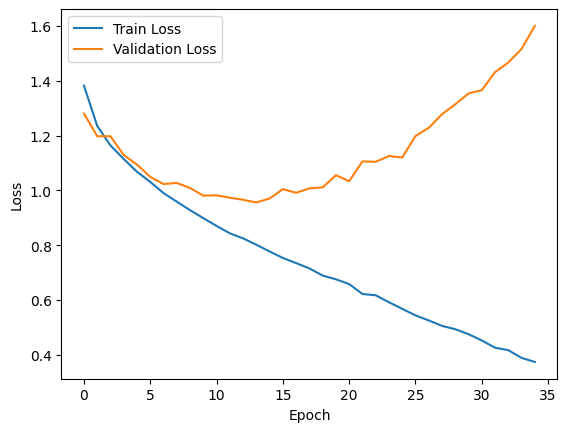

Improved result: acc 0.639, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=300, power=2)
epoch: 13
<class 'torch.optim.lr_scheduler.StepLR'>
99
Epoch   0 | Train Loss: 1.372 | Train Acc:  39.44%
Epoch   0 | Val Loss: 1.267 | Val Acc:  45.24%
learning rate: [0.001]
99
Epoch   1 | Train Loss: 1.236 | Train Acc:  47.19%
Epoch   1 | Val Loss: 1.208 | Val Acc:  47.68%
learning rate: [0.001]
99
Epoch   2 | Train Loss: 1.173 | Train Acc:  50.57%
Epoch   2 | Val Loss: 1.148 | Val Acc:  52.03%
learning rate: [0.001]
99
Epoch   3 | Train Loss: 1.122 | Train Acc:  53.46%
Epoch   3 | Val Loss: 1.110 | Val Acc:  54.49%
learning rate: [0.001]
99
Epoch   4 | Train Loss: 1.070 | Train Acc:  56.37%
Epoch   4 | Val Loss: 1.073 | Val Acc:  56.32%
learning rate: [0.001]
99
Epoch   5 | Train Loss: 1.032 | Train Acc:  58.47%
Epoch   5 | Val Loss: 1.046 | Val Acc:  58.04%
learning rate: [0.001]
99
Epoch   6 | Train Loss: 0.989 | Train Acc:  60.83%
Epoch   6 | Val L

In [ ]:
epochs = 300
print(get_lr(model_gat.optimizer))
scheduler_list = build_scheduler_list(epochs=epochs,
                                      num_batches=(len(cv19_graph_data_train.data_list)//256) + 4)
print(scheduler_list)
trained_gat = hyperparameter_tuning(model_gat, cv19_graph_data_train,
                                    cv19_graph_data_val, scheduler_list,
                                    batch_size = 256, epochs = epochs)

The reported results for the LSTM + GAT are only for polynomial LR scheduler, as the other ones were tested in previous runs.

The best results were obtained with the Cosine annealing scheduler with eta_min = 1e-8 and T_max = 300.

The valdation accuracy reached 68.95% which is the best result reported with a Graph-based network.

The last model to be tested is the BiLSTM + GAT with GLoVe embeddings.

The chosen parameters were:
- dim_in = 100;
- n_filters = 10;
- dim_out = 5;
- heads = 10;

While as hyperparameters we put:
- maximum number of epochs to 300;
- early stopping with patience equal to 10 and min_delta = 0.2;
- batch size to 256.

In [ ]:
model_gat = GAT_bilstm(cv19_graph_data_train.num_node_features,
                cv19_graph_data_train.num_classes*2,
                cv19_graph_data_train.num_classes, heads = 10).to(device)
print(model_gat)

0.001
[functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=300, power=2), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=100, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=75, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-06), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-07), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-08), functools.partial(<class 'torch.optim.lr_scheduler.OneCycleLR'>, max_lr=0.001, steps_per_epoch=103, epochs=300, anneal_strategy='cos')]
batch size: 256
<class 'torch.optim.lr_scheduler.PolynomialLR'>
99
Epoch   0 | Train Loss: 1.375 | Train Acc:  39.32%
Epoch   0 | Val Loss: 1.270 | Val Acc:  45.71%
learning rate: [0.0009933444444444445]
99
Epoch   1 | Train Loss: 1.226 | Train Acc:  48.01%
Epoch   1 | Val Loss: 1.191 | Val

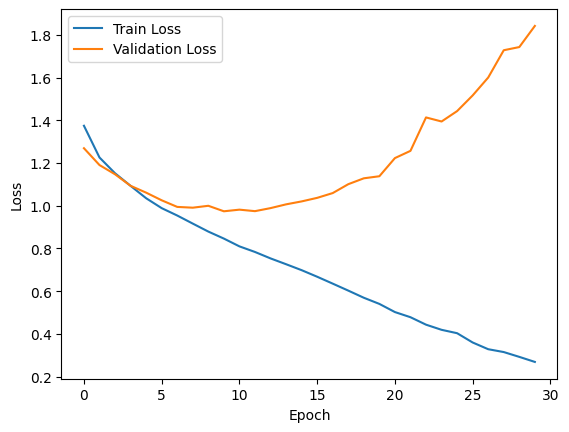

Improved result: acc 0.641, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=300, power=2)
epoch: 12
<class 'torch.optim.lr_scheduler.StepLR'>
99
Epoch   0 | Train Loss: 1.379 | Train Acc:  39.50%
Epoch   0 | Val Loss: 1.260 | Val Acc:  45.93%
learning rate: [0.001]
99
Epoch   1 | Train Loss: 1.231 | Train Acc:  47.52%
Epoch   1 | Val Loss: 1.195 | Val Acc:  48.91%
learning rate: [0.001]
99
Epoch   2 | Train Loss: 1.155 | Train Acc:  51.45%
Epoch   2 | Val Loss: 1.147 | Val Acc:  51.96%
learning rate: [0.001]
99
Epoch   3 | Train Loss: 1.090 | Train Acc:  55.40%
Epoch   3 | Val Loss: 1.092 | Val Acc:  54.96%
learning rate: [0.001]
99
Epoch   4 | Train Loss: 1.035 | Train Acc:  58.28%
Epoch   4 | Val Loss: 1.060 | Val Acc:  57.34%
learning rate: [0.001]
99
Epoch   5 | Train Loss: 0.989 | Train Acc:  61.21%
Epoch   5 | Val Loss: 1.017 | Val Acc:  59.31%
learning rate: [0.001]
99
Epoch   6 | Train Loss: 0.937 | Train Acc:  63.84%
Epoch   6 | Val L

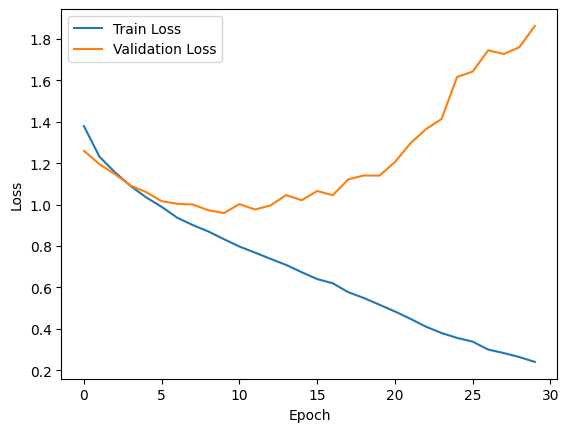

<class 'torch.optim.lr_scheduler.StepLR'>
99
Epoch   0 | Train Loss: 1.392 | Train Acc:  38.00%
Epoch   0 | Val Loss: 1.265 | Val Acc:  46.39%
learning rate: [0.001]
99
Epoch   1 | Train Loss: 1.228 | Train Acc:  47.57%
Epoch   1 | Val Loss: 1.193 | Val Acc:  50.33%
learning rate: [0.001]
99
Epoch   2 | Train Loss: 1.157 | Train Acc:  51.50%
Epoch   2 | Val Loss: 1.146 | Val Acc:  52.08%
learning rate: [0.001]
99
Epoch   3 | Train Loss: 1.100 | Train Acc:  54.59%
Epoch   3 | Val Loss: 1.097 | Val Acc:  55.01%
learning rate: [0.001]
99
Epoch   4 | Train Loss: 1.048 | Train Acc:  57.24%
Epoch   4 | Val Loss: 1.057 | Val Acc:  57.25%
learning rate: [0.001]
99
Epoch   5 | Train Loss: 1.000 | Train Acc:  60.48%
Epoch   5 | Val Loss: 1.028 | Val Acc:  59.54%
learning rate: [0.001]
99
Epoch   6 | Train Loss: 0.952 | Train Acc:  63.16%
Epoch   6 | Val Loss: 1.022 | Val Acc:  59.11%
learning rate: [0.001]
99
Epoch   7 | Train Loss: 0.923 | Train Acc:  64.46%
Epoch   7 | Val Loss: 0.999 | Val Ac

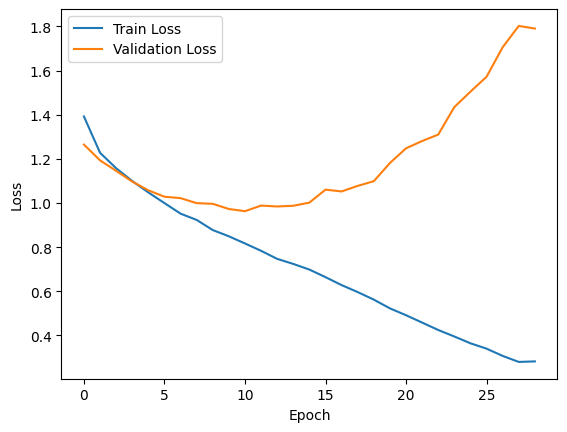

<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
99
Epoch   0 | Train Loss: 1.380 | Train Acc:  39.06%
Epoch   0 | Val Loss: 1.281 | Val Acc:  44.65%
learning rate: [0.0009999726120980734]
99
Epoch   1 | Train Loss: 1.224 | Train Acc:  48.16%
Epoch   1 | Val Loss: 1.193 | Val Acc:  49.28%
learning rate: [0.0009998904513956854]
99
Epoch   2 | Train Loss: 1.154 | Train Acc:  51.47%
Epoch   2 | Val Loss: 1.131 | Val Acc:  53.53%
learning rate: [0.0009997535269026829]
99
Epoch   3 | Train Loss: 1.092 | Train Acc:  55.17%
Epoch   3 | Val Loss: 1.100 | Val Acc:  55.08%
learning rate: [0.0009995618536343797]
99
Epoch   4 | Train Loss: 1.035 | Train Acc:  58.44%
Epoch   4 | Val Loss: 1.083 | Val Acc:  56.07%
learning rate: [0.0009993154526099096]
99
Epoch   5 | Train Loss: 0.999 | Train Acc:  60.74%
Epoch   5 | Val Loss: 1.028 | Val Acc:  59.06%
learning rate: [0.0009990143508499217]
99
Epoch   6 | Train Loss: 0.945 | Train Acc:  63.43%
Epoch   6 | Val Loss: 0.996 | Val Acc:  61.33%
learni

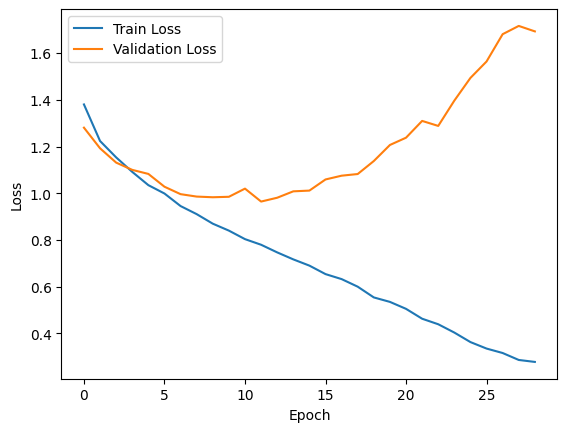

Improved result: acc 0.643, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-06)
epoch: 13
<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
99
Epoch   0 | Train Loss: 1.377 | Train Acc:  39.17%
Epoch   0 | Val Loss: 1.263 | Val Acc:  45.59%
learning rate: [0.0009999725874242878]
99
Epoch   1 | Train Loss: 1.228 | Train Acc:  47.80%
Epoch   1 | Val Loss: 1.194 | Val Acc:  49.73%
learning rate: [0.000999890352703249]
99
Epoch   2 | Train Loss: 1.156 | Train Acc:  51.57%
Epoch   2 | Val Loss: 1.135 | Val Acc:  53.04%
learning rate: [0.0009997533048548475]
99
Epoch   3 | Train Loss: 1.099 | Train Acc:  54.77%
Epoch   3 | Val Loss: 1.103 | Val Acc:  53.96%
learning rate: [0.0009995614589079242]
99
Epoch   4 | Train Loss: 1.043 | Train Acc:  58.08%
Epoch   4 | Val Loss: 1.084 | Val Acc:  55.18%
learning rate: [0.0009993148359005491]
99
Epoch   5 | Train Loss: 1.004 | Train Acc:  60.65%
Epoch   5 | Val Loss: 1.019 | Val Acc:  59.59%

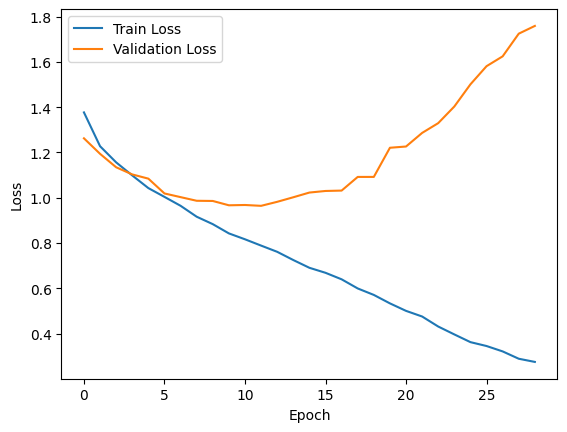

<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
99
Epoch   0 | Train Loss: 1.377 | Train Acc:  39.50%
Epoch   0 | Val Loss: 1.284 | Val Acc:  44.68%
learning rate: [0.0009999725849569093]
99
Epoch   1 | Train Loss: 1.223 | Train Acc:  47.78%
Epoch   1 | Val Loss: 1.212 | Val Acc:  47.98%
learning rate: [0.0009998903428340053]
99
Epoch   2 | Train Loss: 1.151 | Train Acc:  51.79%
Epoch   2 | Val Loss: 1.137 | Val Acc:  53.13%
learning rate: [0.0009997532826500639]
99
Epoch   3 | Train Loss: 1.089 | Train Acc:  55.56%
Epoch   3 | Val Loss: 1.086 | Val Acc:  55.57%
learning rate: [0.0009995614194352785]
99
Epoch   4 | Train Loss: 1.039 | Train Acc:  58.44%
Epoch   4 | Val Loss: 1.056 | Val Acc:  57.12%
learning rate: [0.000999314774229613]
99
Epoch   5 | Train Loss: 0.998 | Train Acc:  60.39%
Epoch   5 | Val Loss: 1.043 | Val Acc:  58.25%
learning rate: [0.0009990133740804936]
99
Epoch   6 | Train Loss: 0.948 | Train Acc:  63.44%
Epoch   6 | Val Loss: 1.009 | Val Acc:  60.83%
learnin

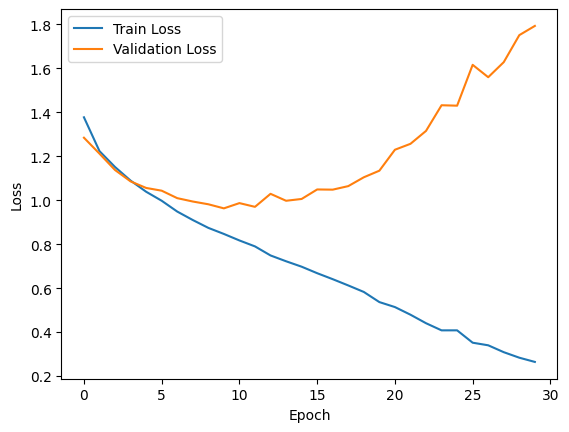

<class 'torch.optim.lr_scheduler.OneCycleLR'>
99
Epoch   0 | Train Loss: 1.553 | Train Acc:  29.37%
Epoch   0 | Val Loss: 1.531 | Val Acc:  31.33%
learning rate: [4.027567897599423e-05]
99
Epoch   1 | Train Loss: 1.506 | Train Acc:  32.15%
Epoch   1 | Val Loss: 1.488 | Val Acc:  33.40%
learning rate: [4.110239924190267e-05]
99
Epoch   2 | Train Loss: 1.464 | Train Acc:  34.57%
Epoch   2 | Val Loss: 1.442 | Val Acc:  36.41%
learning rate: [4.24792111752407e-05]
99
Epoch   3 | Train Loss: 1.407 | Train Acc:  37.93%
Epoch   3 | Val Loss: 1.381 | Val Acc:  39.25%
learning rate: [4.440453328390852e-05]
99
Epoch   4 | Train Loss: 1.348 | Train Acc:  41.21%
Epoch   4 | Val Loss: 1.328 | Val Acc:  42.05%
learning rate: [4.687615402279219e-05]
99
Epoch   5 | Train Loss: 1.312 | Train Acc:  43.34%
Epoch   5 | Val Loss: 1.311 | Val Acc:  43.32%
learning rate: [4.989123433408191e-05]
99
Epoch   6 | Train Loss: 1.290 | Train Acc:  44.51%
Epoch   6 | Val Loss: 1.290 | Val Acc:  43.51%
learning rate:

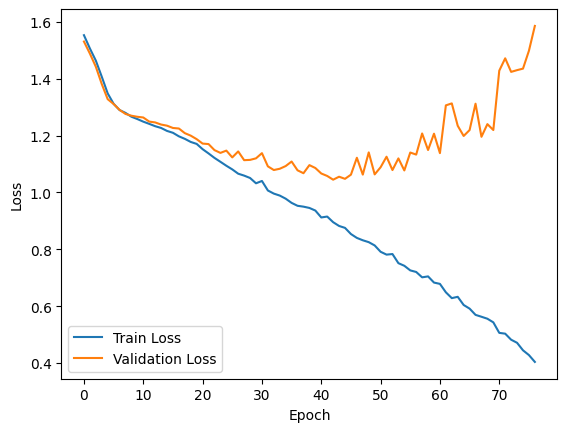

In [ ]:
epochs = 300
print(get_lr(model_gat.optimizer))
scheduler_list = build_scheduler_list(epochs=epochs,
                                      num_batches=(len(cv19_graph_data_train.data_list)//256) + 4)
print(scheduler_list)
trained_gat = hyperparameter_tuning(model_gat, cv19_graph_data_train,
                                    cv19_graph_data_val, scheduler_list,
                                    batch_size = 256, epochs = epochs)

The best results were obtained the Cosine Annealing scheduler with T_max=300 and eta_min = 1e-6, yielding a val. Accuracy of 64.3% after 13 epochs.

Since the results were worse than the previous model, this model is not added to the final report.

## Evaluation
In the end, we propose the evaluation of the best graph-based model, that is the one with LSTM + GAT

In [61]:
# Loadin the model
saved_dict = torch.load("./ckpts/GAT_best_CosineAnnealingLR_2_ckpt")
model_gat.load_state_dict(saved_dict)
trained_gat_model = model_gat

In [62]:
def diff_idxs(v1, v2):
  """
  computes which batch samples (indexes) are different w.r.t the ones in another batch
  :param v1: first tensor to be compared
  :param v2: second tensor to be compared
  :returns: the array containing the indexes where there are mis-matching values between v1 and v2
  """
  to_return = []
  for i in range(0, v1.shape[0]):
    if v1[i] != v2[i]:
      to_return.append(i)
  return np.array(to_return)

In [63]:
def eval_model(model, loader_val, criterion, batch_size):
  """
  performs model evaluation
  :params model: model to be evaluated
  :params loader_val: torch DataLoader for the validation set
  :params criterion: loss to be computed
  :params batch size: batch dimension for inference
  """
  mean_loss_val = 0
  mean_acc_val = 0
  model.eval()
  # indexes of the wrongly classified samples
  idx_wrong_samples = np.array([], dtype = int)
  # full indexes of wrongly classified samples
  model_wrong_predictions = np.array([], dtype = int)
  # correct labels
  correct_labels = np.array([], dtype = int)
  # full predictions obtained from the model
  all_predictions = np.array([], dtype = int)
  with torch.no_grad():
      for i, batch in tqdm(enumerate(loader_val)):
        # get predictions, loss and accuracy
        out = model(batch.x.to(device), batch.edge_index.to(device), batch.batch.to(device))
        loss_val = criterion(out, batch.y.long().to(device))
        mean_loss_val += loss_val.item()
        acc_val = accuracy(out.argmax(dim=1), batch.y.to(device))
        mean_acc_val += acc_val
        # separate good and wrong predictions
        within_batch_misscl_idxs = diff_idxs(out.argmax(dim=1).cpu(), batch.y.cpu())
        curr_idx_wrong_samples = (batch_size * i) + within_batch_misscl_idxs
        model_wrong_predictions = np.concatenate((model_wrong_predictions, out.argmax(dim=1).cpu()[within_batch_misscl_idxs]))
        all_predictions = np.concatenate((all_predictions, out.argmax(dim=1).cpu()))
        idx_wrong_samples = np.concatenate((idx_wrong_samples, curr_idx_wrong_samples))
        correct_labels = np.concatenate((correct_labels, batch.y.cpu()[within_batch_misscl_idxs]))
        #visualize_embedding(embed, batch.y, epoch, loss_val)
      mean_loss_val /= (i + 1)
      mean_acc_val /= (i + 1)
  return mean_loss_val, mean_acc_val, idx_wrong_samples, model_wrong_predictions, correct_labels, all_predictions

In [64]:
batch_size = 64
#trained_gat_model = trained_gat[1]
loader_test = DataLoader(cv19_graph_data_test.data_list, batch_size=batch_size, shuffle=False)
criterion = torch.nn.CrossEntropyLoss(label_smoothing = 0.01)
mean_loss_test, mean_acc_test, idx_wrong_samples, model_wrong_predictions, correct_labels, all_predictions = eval_model(trained_gat_model, \
                                                                                                        loader_test, criterion, batch_size)

125it [00:10, 12.33it/s]


In [65]:
print(f'Test loss: {mean_loss_test}')
print(f'Test accuracy: {mean_acc_test}')

Test loss: 0.959695487499237
Test accuracy: 0.6867727274894715


In [66]:
print(len(idx_wrong_samples))

2499


In [67]:
def num_labels_to_text_labels(labels):
    lab_dict={
        0:'Extremely Negative',
        1:'Negative',
        2:'Neutral',
        3:'Positive',
        4:'Extremely Positive'
    }
    labels = list(map(lab_dict.get, labels))
    #print(labels)
    
    return labels

In [68]:
report = classification_report(np.array(cv19_graph_data_test.y_values), np.array(all_predictions))
print(report)

              precision    recall  f1-score   support

           0       0.75      0.67      0.71      1087
           1       0.61      0.67      0.64      1938
           2       0.77      0.69      0.73      1402
           3       0.64      0.72      0.67      2236
           4       0.80      0.66      0.73      1317

    accuracy                           0.69      7980
   macro avg       0.71      0.68      0.70      7980
weighted avg       0.70      0.69      0.69      7980



In [69]:
def plot_missclassification_histogram(correct_labels, model_wrong_predictions, label):
    from collections import Counter
    import matplotlib.pyplot as plt
    missclass = []
    idx_label = np.where(correct_labels == label)
    missclass = model_wrong_predictions[idx_label]
    dict_counts = dict(Counter(missclass))
    to_plot = plt.bar(num_labels_to_text_labels(list(dict_counts.keys())), list(dict_counts.values()))
    plt.xticks(rotation = 45)
    plt.show()

Missclassification histogram for label: Extremely Negative


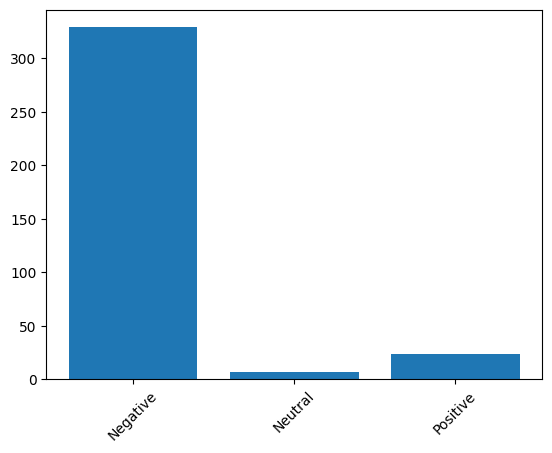

Missclassification histogram for label: Negative


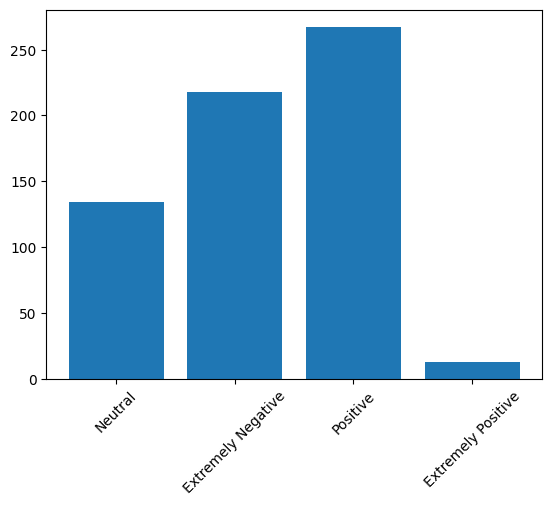

Missclassification histogram for label: Neutral


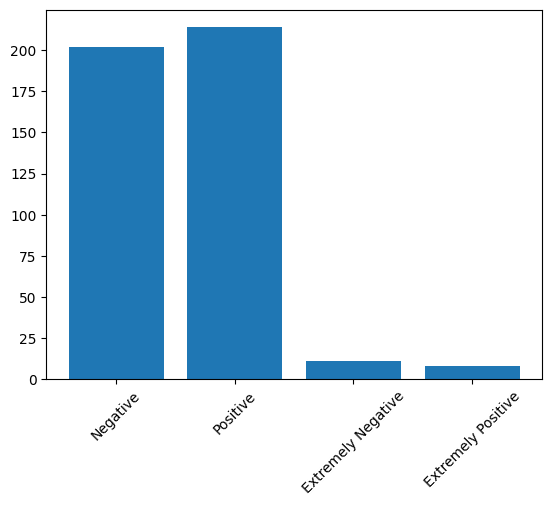

Missclassification histogram for label: Positive


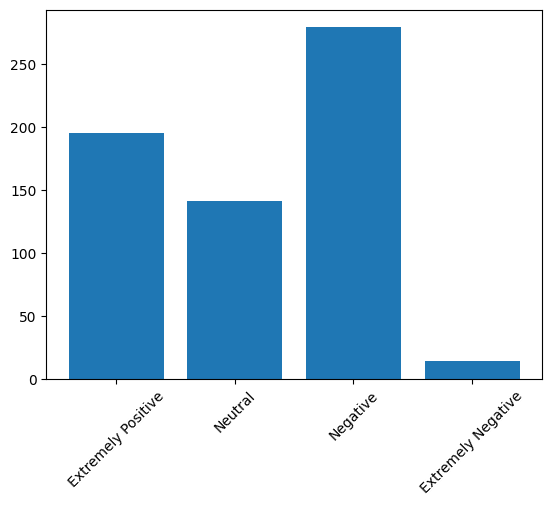

Missclassification histogram for label: Extremely Positive


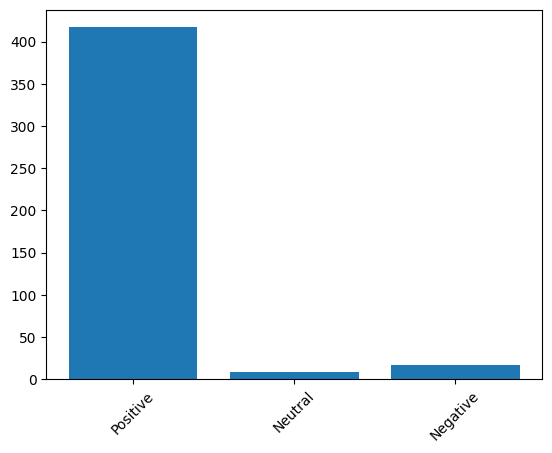

In [75]:
for label in range(0, 5):
    print(f'Missclassification histogram for label: {num_labels_to_text_labels([label])[0]}')
    plot_missclassification_histogram(correct_labels, model_wrong_predictions, label)

In [76]:
tweet_list = [cv19_graph_data_test.sentences_list[i] for i in idx_wrong_samples]
#gt_list = num_labels_to_text_labels([cv19_graph_data_test.y_values[i] for i in idx_wrong_samples])
gt_list = num_labels_to_text_labels(correct_labels)
pred_labels = num_labels_to_text_labels(model_wrong_predictions)

eval_dict = {'Tweets':tweet_list, 'Ground Truth': gt_list, 'Predicted Labels': pred_labels}
df_eval = pd.DataFrame(eval_dict)
df_eval.head

<bound method NDFrame.head of                                                  Tweets        Ground Truth  \
0     how beautiful the way to the supermarket can b...            Positive   
1     ani bsbommai sir, lockdown is the right step t...  Extremely Positive   
2     petrol diesel prices static for rd successive ...            Positive   
3     itv news coronavirus how to avoid fraudsters d...  Extremely Negative   
4     covid- grocery prices start to rise as cost in...            Negative   
...                                                 ...                 ...   
2494  governors of the states under the aegis of the...             Neutral   
2495  just heard a fella in the supermarket clearly ...            Positive   
2496  interesting - consumer optimism in italy, spai...  Extremely Positive   
2497  . liter na lang unleaded gas sa amin. sana mag...             Neutral   
2498  triathlonbadboy hi there. we want to assure yo...  Extremely Positive   

        Predicted Lab

In [95]:
def get_entries_missclasslabels(df_eval, label, ground_truth):
    return df_eval[((df_eval['Predicted Labels']==label) & (df_eval['Ground Truth']==ground_truth))]


In [111]:
e_n_n = get_entries_missclasslabels(df_eval, 'Extremely Negative', 'Negative')
n_p = get_entries_missclasslabels(df_eval, 'Negative', 'Positive')
neu_p = get_entries_missclasslabels(df_eval, 'Neutral', 'Positive')
neu_n = get_entries_missclasslabels(df_eval, 'Neutral', 'Negative')
p_n = get_entries_missclasslabels(df_eval, 'Positive', 'Negative')
e_p_p = get_entries_missclasslabels(df_eval, 'Positive', 'Extremely Positive')

In [125]:
e_n_n.iloc[0, :]

Tweets              i predict unemployment look only unemployment ...
Ground Truth                                                 Negative
Predicted Labels                                   Extremely Negative
Name: 17, dtype: object

In [127]:
e_n_n.iloc[2, :].values

array(['just visited aldi at hawthorn adelaide and all meats, canned food among other things gone. panic buying due to coronavirus is insane what happens to those who are not panic buying and have a family to feed and keep healthy ',
       'Negative', 'Extremely Negative'], dtype=object)

In [129]:
n_p.iloc[2, :].values

array(['thread interested to see what impacts covid has on a number of things as a result of working at home, self isolation. eg how will online behaviours change and stick online shopping, delivery services, media consumption ',
       'Positive', 'Negative'], dtype=object)

In [119]:
neu_p.iloc[0, :].values

array(['petrol diesel prices static for rd successive day amid covid nationwide lockdown key things to know',
       'Positive', 'Neutral'], dtype=object)

In [131]:
neu_n.iloc[2, :].values

array(['with new state guidelines on how grocery store employees can interact with the public..stop yelling at workers because deli items are grab and go you rant over. coronavirus bekind',
       'Negative', 'Neutral'], dtype=object)

In [132]:
p_n.iloc[1, :].values

array(["food banks are really struggling, and they're the last line of defence for many of the most disadvantaged in our communities. please consider donating next time you're in a supermarket. covid_ foodshortages ",
       'Negative', 'Positive'], dtype=object)

In [135]:
e_p_p.iloc[3, :].values

array(['the german chancellor nailed it with this line those who sit at supermarket cash registers or restock shelves are doing one of the hardest jobs there is right now.a be kind and show courtesy and respect covid on covid covidcanada covid ',
       'Extremely Positive', 'Positive'], dtype=object)